In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import numpy as np
import os
import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
path="CorsicanDB/training/rgb"
import torch
import torch.nn as nn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
#path='/content/drive/My Drive/CorsicanDB/training/rgb/'

In [367]:
training_data=[]
def dataset():
    count=0
    for img in os.listdir(path):
        #count+=1
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(500,500))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        training_data.append(img_array)
        #if count>15000:
        #    break
dataset()

In [368]:
training_data=np.array(training_data)

In [4]:
image_data=training_data

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True
)

batch_size = 50  
augmentations_per_image = 3  
total_batches = len(image_data) // batch_size

augmented_images = []

for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    batch_data = image_data[start_idx:end_idx]

    for aug_idx in range(augmentations_per_image):
        for augmented_batch in datagen.flow(batch_data, batch_size=batch_size, shuffle=False):
            augmented_images.append(augmented_batch)  
            break  

if len(image_data) % batch_size != 0:
    batch_data = image_data[total_batches * batch_size:]
    for aug_idx in range(augmentations_per_image):
        for augmented_batch in datagen.flow(batch_data, batch_size=len(batch_data), shuffle=False):
            augmented_images.append(augmented_batch)
            break

augmented_images = np.concatenate(augmented_images)

print(f"Augmented dataset shape: {augmented_images.shape}")



Augmented dataset shape: (1785, 500, 500, 3)


In [2]:
class CAE(nn.Module):
    def __init__(self, num_features, device):
        super(CAE, self).__init__()

        # Encoder Layers
        self.conv0 = nn.Conv2d(num_features, 8, kernel_size=3, padding=1)
        self.bn0 = nn.BatchNorm2d(8)
        self.act0 = nn.ELU(True)

        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ELU(True)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ELU(True)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ELU(True)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.ELU(True)

        # Decoder Layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(8, num_features, kernel_size=3, padding=1),
            nn.ELU(True)
        )

        self.device=device
        self.num_features=num_features

    def create_attention_block(self, channels,device):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), 
            nn.Linear(channels, channels // 2).to(device), 
            nn.ReLU(inplace=True).to(device),
            nn.Linear(channels // 2, channels).to(device),  
            nn.Sigmoid().to(device)  
        )

    def apply_attention(self, x, device):
        b, c, _, _ = x.size()
        attention_block = self.create_attention_block(c,device) 
        x = x.to(device)  
        attention_weights = attention_block(x).view(b, c, 1, 1)  
        return x *  (0.5+attention_weights),(0.5+attention_weights)  


    def get_embedding(self, x, device):
       
        x = x.permute(0, 3, 2, 1)  

        x = self.conv0(x)
        x = self.bn0(x)
        x = self.act0(x)

        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.act1(x)

        
        x,__= self.apply_attention(x,device)

        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.act3(x)

        
        x,weights= self.apply_attention(x,device)

       
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)

        return x,weights

    def forward(self, x,device):
        x,__= self.get_embedding(x,device)

        x,weights = self.apply_attention(x,device)

        x = self.decoder(x)

        x = torch.reshape(x, (x.shape[0], self.num_features, 500, 500))
        x = x.permute(0, 3, 2, 1)
        return x,weights



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [369]:
loader=torch.FloatTensor(augmented_images)

In [8]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [370]:
#loader= TS_Dataset(training_data)
trainloader = torch.utils.data.DataLoader(loader, batch_size=32,
                                          shuffle=True)
net = CAE(num_features = 3,device=device).to(device)
net = net.train()

In [10]:
import torch.optim as optim
import torch.nn.functional as F

epoch_counts = 5
lr = 0.001
lambda_reg = 0.1  

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=lr)

train_losses = []
train_avg_losses = []

def color_aware_regularization(outputs, inputs):
    red_input = inputs[:, :, :, 0] 


    red_output = outputs[:, :, :, 0]

    reg_loss = F.mse_loss(red_output, red_input)

    return reg_loss

for epoch in range(epoch_counts):
    running_loss = 0.0
    epoch_avg_loss = 0
    i = 1

    for data in trainloader:
        inputs = data.to(device)

        optimizer.zero_grad()

        outputs,weights= net(inputs,device)

        mse_loss = criterion(outputs, inputs)

        reg_loss = color_aware_regularization(outputs, inputs)

        total_loss = mse_loss + (lambda_reg * reg_loss)

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        epoch_avg_loss += total_loss.item()

        if i % 4 == 3:
            print(f'\n[{epoch + 1}] loss: {running_loss / 4:.3f} , avg_loss {epoch_avg_loss / i:.3f}\n')
            train_avg_losses.append(epoch_avg_loss / i)
            train_losses.append(running_loss / 4)
            running_loss = 0.0

        i += 1



[1] loss: 0.278 , avg_loss 0.370


[1] loss: 0.203 , avg_loss 0.275


[1] loss: 0.083 , avg_loss 0.205


[1] loss: 0.048 , avg_loss 0.163


[1] loss: 0.029 , avg_loss 0.135


[1] loss: 0.028 , avg_loss 0.116


[1] loss: 0.023 , avg_loss 0.103


[1] loss: 0.017 , avg_loss 0.092


[1] loss: 0.016 , avg_loss 0.083


[1] loss: 0.017 , avg_loss 0.076


[1] loss: 0.017 , avg_loss 0.071


[1] loss: 0.014 , avg_loss 0.066


[1] loss: 0.011 , avg_loss 0.062


[1] loss: 0.008 , avg_loss 0.058


[2] loss: 0.007 , avg_loss 0.010


[2] loss: 0.009 , avg_loss 0.009


[2] loss: 0.008 , avg_loss 0.009


[2] loss: 0.007 , avg_loss 0.008


[2] loss: 0.007 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.007 , avg_loss 0.008


[2] loss: 0.008 , avg_loss 0.008


[2] loss: 0.006 , avg_loss 0.008


[2] loss: 0.006 , avg_loss 0.007


[2] loss: 0.007 , avg_loss 0.007


[2] loss: 0.006 , avg_loss 0.007


[2] loss: 0.006 , avg_loss 0.007


[2] loss: 0.005 , avg_loss 0.007


[3] loss: 0.004 , a

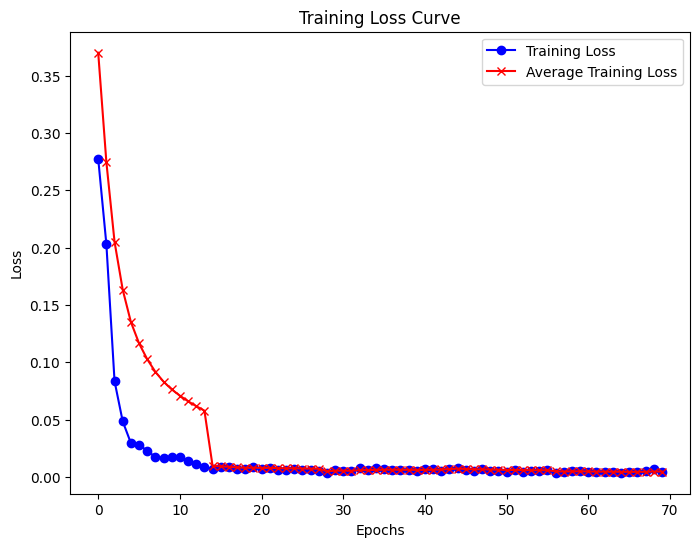

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(train_losses)), train_losses, 'bo-', label='Training Loss')
plt.plot(range(len(train_avg_losses)), train_avg_losses, 'rx-', label='Average Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [12]:
torch.save(net, 'autoencode_epoch_not_best(pc with colour attention block bw conv)'+str(epoch+1))

In [4]:
net=torch.load("autoencode_epoch_best(pc with colour attention block bw conv and red regularization)5").to(device)


C:\Users\prabh\AppData\Local\Temp\ipykernel_17468\1653870668.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net=torch.load("autoencode_epoch_best(pc with colour attenti

In [154]:
img_no='510'
testpath=f"CorsicanDB/training/rgb/{img_no}_rgb.png"
#testpath="FLAME dataset/Training/Training/Fire/resized_frame9.jpg"
#testpath='test images/1.webp'
img_test=cv2.imread(testpath)
img_test=cv2.resize(img_test,(500,500))
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
test=np.array(img_test)
test=torch.FloatTensor(test)


In [155]:
d=test
d=torch.FloatTensor(d)
d = d.unsqueeze(0)
d=d.to(device)
output,weights=net(d,device)

In [156]:
output1=output.squeeze(0)
output1.shape
output12=output1.detach().cpu().numpy()
output12.shape
output_np = (output12 - output12.min()) / (output12.max() - output12.min())


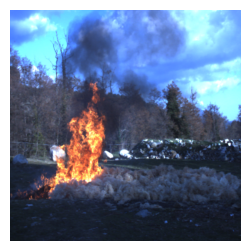

In [157]:
plt.figure(figsize=(3,3))
plt.imshow(img_test)
plt.axis("off")
plt.show()

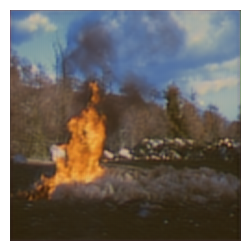

In [158]:
plt.figure(figsize=(3,3))
plt.imshow(output_np)
plt.axis("off")
plt.show()

In [159]:
outputs,weights = net.get_embedding(d,device)
#outputs,_=net.attention(outputs)
outputs=outputs.detach().cpu().numpy()
out=(outputs - outputs.min())/(outputs.max()-outputs.min())
out=(out * 255).astype(np.uint8)
out=out.squeeze(0)
outshow=out.transpose(0,2,1)

In [160]:
weights=weights.detach().cpu().numpy()
weights=weights.squeeze(0).squeeze(1).squeeze(1)
weights.shape

(64,)

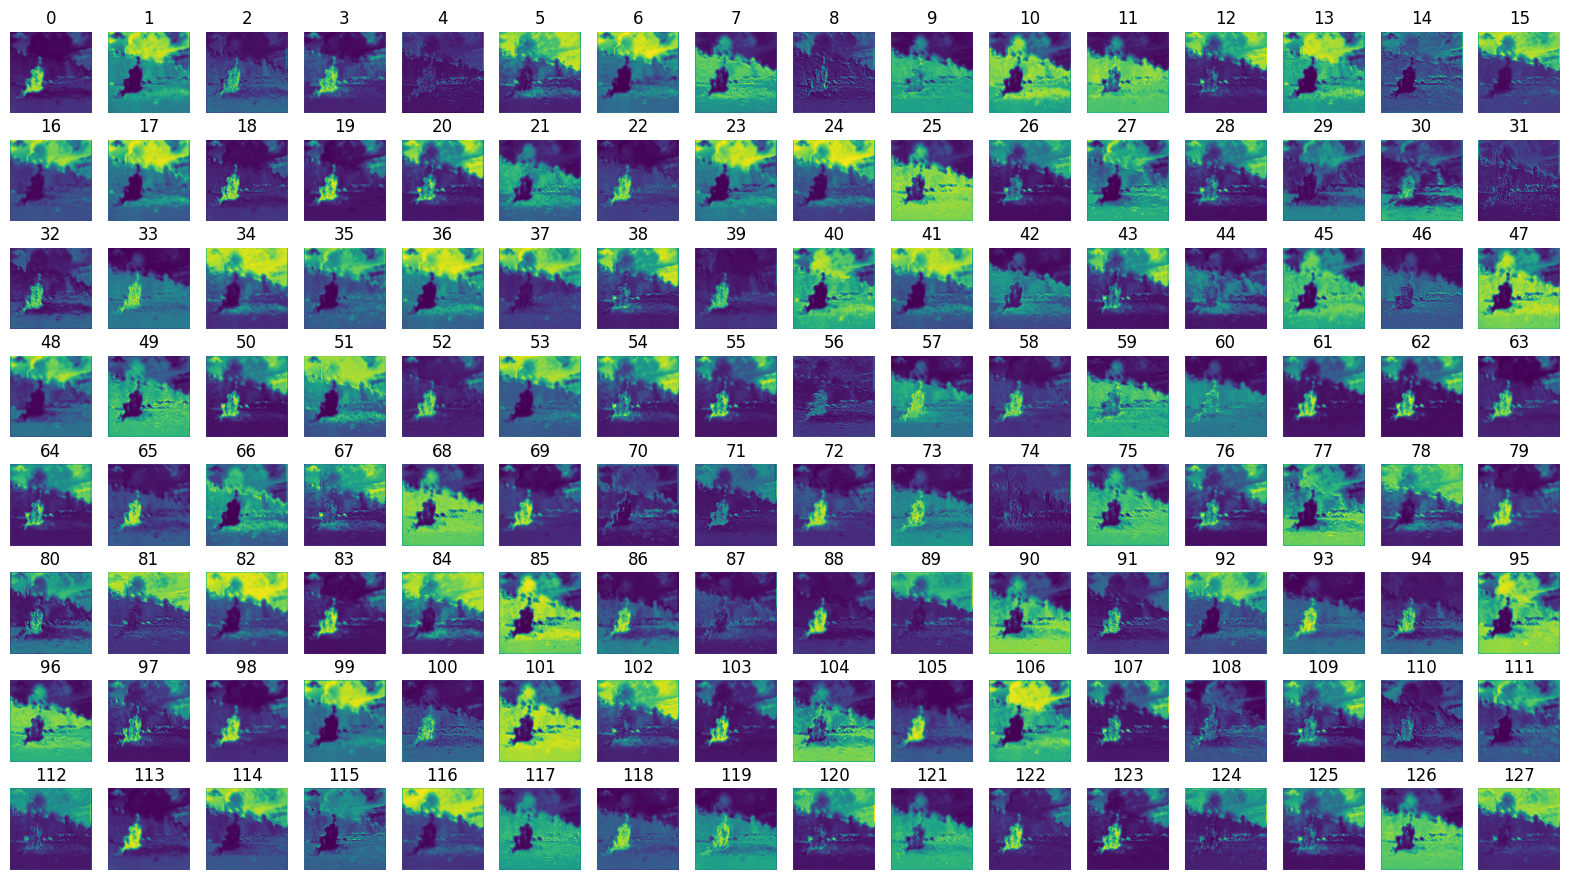

In [161]:
fig, ax = plt.subplots(8, 16,figsize=(20,11))
count=0
for i in range(8):
    for j in range(16):

        ax[i,j].imshow(outshow[count],cmap='viridis')
        ax[i,j].axis('off')
        ax[i,j].title.set_text(count)
        count+=1
plt.show()

In [162]:
feature_arr = np.empty((0,) + outshow[0].shape)
features=[0,113,105,79,39]
count=0
for i in features:
    o=np.expand_dims(outshow[i], axis=0)
    feature_arr=np.append(feature_arr,o,axis=0)
    count+=1
feature_arr.shape

(5, 125, 125)

In [163]:
feature_array=feature_arr.transpose(1,2,0)
outsample=feature_array.reshape((125*125,count))

Input shape: (15625, 5)
Labels shape: (15625,)


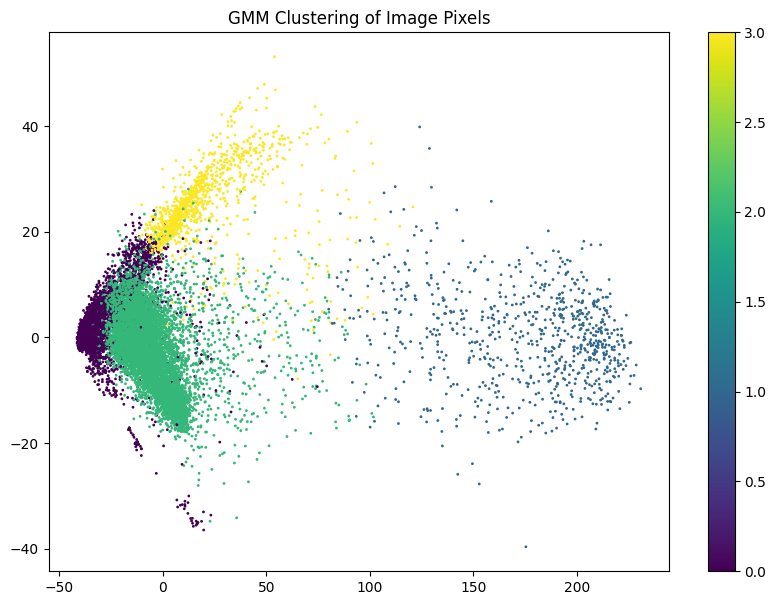

In [174]:
print(f"Input shape: {outsample.shape}")

gmm = GaussianMixture(n_components=4, covariance_type='tied',tol=0.001)
gmm.fit(outsample)
labels = gmm.predict(outsample)

print(f"Labels shape: {labels.shape}")  

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(outsample)
gmm_clustered_image = labels.reshape((125,125))

plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=1)
plt.colorbar()
plt.title('GMM Clustering of Image Pixels')
plt.show()

In [165]:
reduced_data.shape

(15625, 2)

In [166]:
from sklearn.cluster import KMeans
n_clusters = 2

model = KMeans(n_clusters)
model.fit_predict(outsample)
labels = model.labels_  
kmeans_clustered_image = labels.reshape((125,125))

In [167]:
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(outsample, method='ward')  
clusters = fcluster(Z, 3, criterion='maxclust')

hc_clustered_image = clusters.reshape((125,125)) 

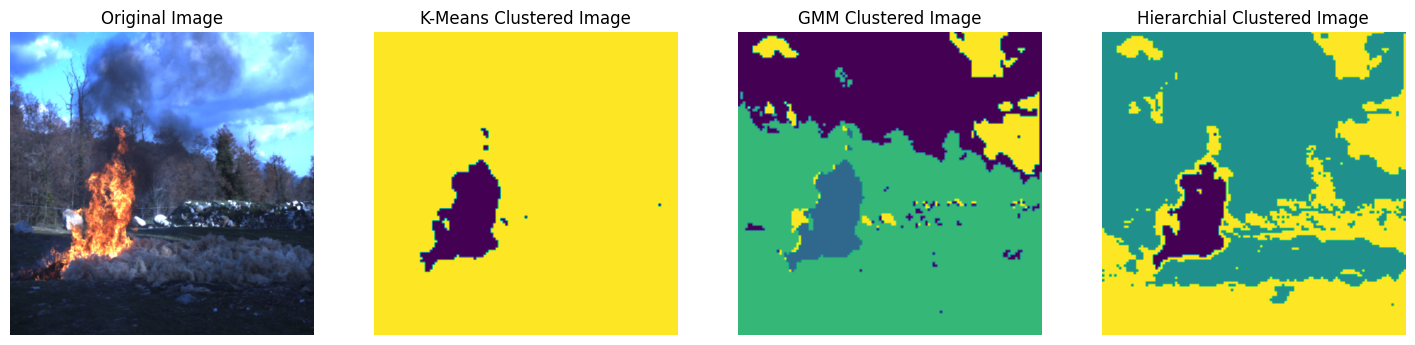

In [175]:
fig, ax = plt.subplots(1, 4, figsize=(18, 12))

ax[0].imshow(img_test)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(kmeans_clustered_image)
ax[1].set_title('K-Means Clustered Image')
ax[1].axis('off')

ax[2].imshow(gmm_clustered_image)
ax[2].set_title('GMM Clustered Image')
ax[2].axis('off')

ax[3].imshow(hc_clustered_image)
ax[3].set_title('Hierarchial Clustered Image')
ax[3].axis('off')
plt.show()

Mean Intensities - Cluster 1: Red: 103.31, Green: 154.29, Blue: 220.16
Mean Intensities - Cluster 2: Red: 199.62, Green: 126.21, Blue: 90.87
Mean Intensities - Cluster 3: Red: 50.19, Green: 56.04, Blue: 74.74
Mean Intensities - Cluster 4: Red: 165.68, Green: 221.42, Blue: 233.21
Best Cluster: 2


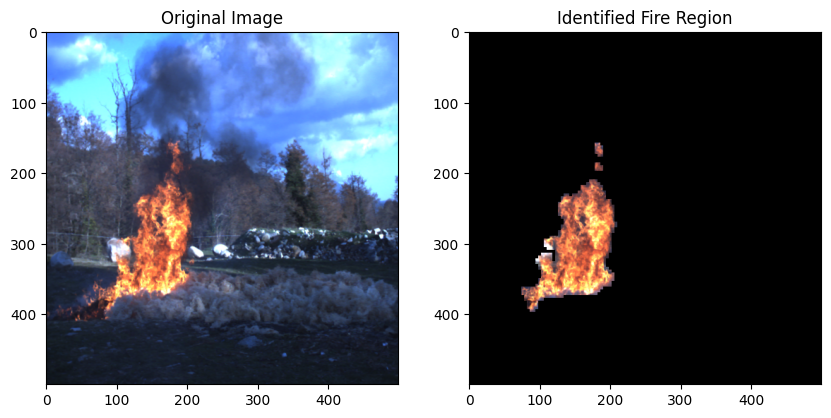

In [183]:
clustering_choice = gmm_clustered_image
num_clusters = np.max(clustering_choice) + 1

cluster_masks = {}
mean_red_intensities = {}

green_threshold = 20
blue_threshold = 20  

for cluster_num in range(num_clusters):
    cluster_mask = np.where(clustering_choice == cluster_num, 255, 0).astype(np.uint8)
    cluster_mask = cv2.resize(cluster_mask, (500, 500), interpolation=cv2.INTER_LINEAR)
    
    cluster_masks[cluster_num] = cluster_mask
    
    red_channel = img_test[:, :, 0]  
    green_channel = img_test[:, :, 1]
    blue_channel = img_test[:, :, 2]
    
    mean_red_intensity = np.mean(red_channel[cluster_mask > 0])
    mean_green_intensity = np.mean(green_channel[cluster_mask > 0])
    mean_blue_intensity = np.mean(blue_channel[cluster_mask > 0])
    
    if mean_red_intensity > mean_green_intensity + green_threshold and mean_red_intensity > mean_blue_intensity + blue_threshold:
        mean_red_intensities[cluster_num] = mean_red_intensity
    
    print(f"Mean Intensities - Cluster {cluster_num + 1}: Red: {mean_red_intensity:.2f}, Green: {mean_green_intensity:.2f}, Blue: {mean_blue_intensity:.2f}")

best_cluster = max(mean_red_intensities, key=mean_red_intensities.get)
print(f"Best Cluster: {best_cluster + 1}")

fire_mask = cluster_masks[best_cluster]
fire_region = cv2.bitwise_and(img_test, img_test, mask=fire_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_test) 

plt.subplot(1, 2, 2)
plt.title("Identified Fire Region")
plt.imshow(fire_region) 

plt.show()


In [177]:
upscaled_img = np.repeat(fire_mask[:, :, np.newaxis], 3, axis=2)

In [178]:
path=f"CorsicanDB/training/gt/{img_no}_gt.png"
gt=cv2.imread(path)
gt=cv2.resize(gt,(500,500))

In [181]:
pred_binary = np.all(upscaled_img == [255, 255, 255], axis=-1).astype(np.uint8)  
gt_binary = np.all(gt == [255, 255, 255], axis=-1).astype(np.uint8)     

intersection = np.logical_and(pred_binary, gt_binary).sum()
union = np.logical_or(pred_binary, gt_binary).sum()

if union == 0:
    miou = 1.0 if intersection == 0 else 0.0
else:
    miou = intersection / union

sum_elements = np.sum(gt_binary) + np.sum(pred_binary)

if sum_elements == 0:
    dice= 1.0  

dice = (2.0 * intersection) / sum_elements

print(f"IoU: {miou:.4f}")
print(f"DICE score: {dice:.4f}")

IoU: 0.7553
DICE score: 0.8606


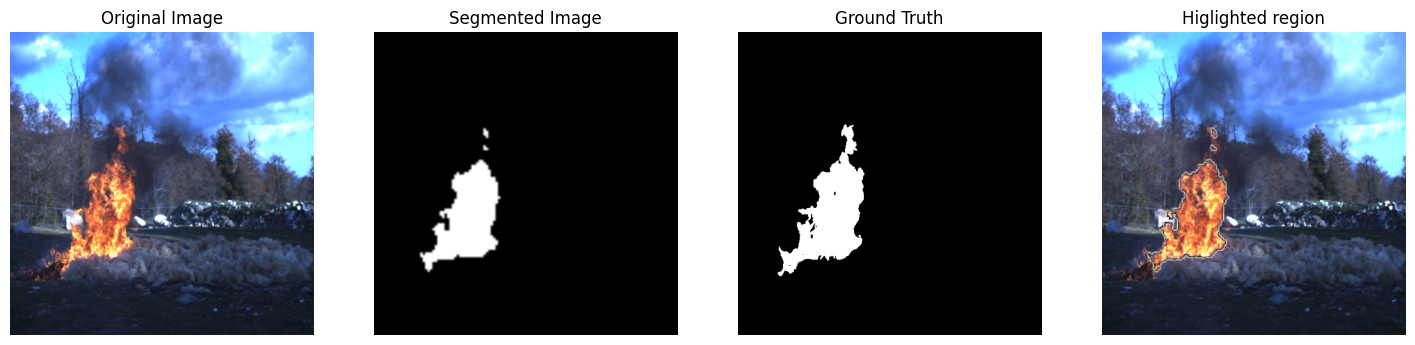

In [180]:
highlighted_image =upscaled_img + img_test
fig, ax = plt.subplots(1, 4, figsize=(18, 12))

ax[0].imshow(img_test)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(upscaled_img, cmap='gray')
ax[1].set_title('Segmented Image')
ax[1].axis('off')

ax[2].imshow(gt, cmap='gray')
ax[2].set_title('Ground Truth')
ax[2].axis('off')

ax[3].imshow(highlighted_image, cmap='gray')
ax[3].set_title('Higlighted region')
ax[3].axis('off')
plt.show()
